In [455]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg

In [456]:
E = 160
v = 1 / 3
lam = E * v / (1 + v) / (1 - 2 * v)
mu = E / 2 / (1 + v)
lam, mu

(119.99999999999999, 60.0)

In [457]:
# Seems to be wrong, https://physik.cosmos-indirekt.de/Physik-Schule/Elastizit%C3%A4tstensor is right
#lam = 120
#mu = 60

E = np.array([
    [lam + 2 * mu, lam, 0],
    [lam, lam + 2 * mu, 0],
    [0, 0, mu]
])
E

array([[240., 120.,   0.],
       [120., 240.,   0.],
       [  0.,   0.,  60.]])

In [458]:
B = np.array([
    [-1, 0, 1, 0, 0, 0],
    [0, -1, 0, 0, 0, 1],
    [-1, -1, 0, 1, 1, 0]
])

In [459]:
k = np.transpose(B) @ E @ B
np.set_printoptions(3, linewidth=200)
k

array([[ 300.,  180., -240.,  -60.,  -60., -120.],
       [ 180.,  300., -120.,  -60.,  -60., -240.],
       [-240., -120.,  240.,    0.,    0.,  120.],
       [ -60.,  -60.,    0.,   60.,   60.,    0.],
       [ -60.,  -60.,    0.,   60.,   60.,    0.],
       [-120., -240.,  120.,    0.,    0.,  240.]])

In [460]:
np.linalg.matrix_rank(k)

3

In [461]:
Field = np.array([
    [True, False, False],
    [True, True, True],
    [True, False, False]
])

In [462]:
counter = 0
positionsIn = []

edgesOnRectangle = np.array([(0, 0), (1, 0), (1, 1), (0, 1)])

for x in range(Field.shape[0]):
    for y in range(Field.shape[1]):
        if Field[x, y]:
            for edge in edgesOnRectangle:
                pos = edge + (x, y)
                pos = (pos[0], pos[1])
                if pos not in positionsIn:
                    counter += 1
                    positionsIn.append(pos)


# Effective method for calculating K
KGlob = np.zeros((2 * counter, 2 * counter))

for x in range(Field.shape[0]):
    for y in range(Field.shape[1]):
        if Field[x, y]:
            evenI = lambda pos: positionsIn.index((x + pos[0], y + pos[1])) * 2
            oddI = lambda pos: positionsIn.index((x + pos[0], y + pos[1])) * 2 + 1

            targetIndices = [evenI((0, 0)), oddI((0, 0)), evenI((1, 0)), oddI((1, 0)), evenI((0, 1)), oddI((0, 1))]

            for i in range(k.shape[0]):
                for j in range(k.shape[1]):
                    KGlob[targetIndices[i], targetIndices[j]] += k[i, j]

            targetIndices = [evenI((1, 1)), oddI((1, 1)), evenI((0, 1)), oddI((0, 1)), evenI((1, 0)), oddI((1, 0))]

            for i in range(k.shape[0]):
                for j in range(k.shape[1]):
                    KGlob[targetIndices[i], targetIndices[j]] += k[i, j]
KGlob = np.delete(np.delete(KGlob, 22, 0), 22, 1)
KGlob = np.delete(np.delete(KGlob, 21, 0), 21, 1)
KGlob = np.delete(np.delete(KGlob, 20, 0), 20, 1)
KGlobBack = KGlob
KGlob.shape

(21, 21)

In [463]:
np.linalg.matrix_rank(KGlob)

21

In [464]:
f = np.zeros((KGlob.shape[0], 1))
f[18] = 10

In [465]:
# https://en.wikipedia.org/wiki/Conjugate_gradient_method

x_k = np.zeros((KGlob.shape[1], 1))
r_k = f - KGlob @ x_k
p_k = r_k
for k in range(50):
    alpha_k = r_k.transpose() @ r_k / (p_k.transpose() @ KGlob @ p_k)
    x_k1 = x_k + alpha_k * p_k
    r_k1 = r_k - alpha_k * KGlob @ p_k
    if np.linalg.norm(r_k1) < 1e-20:
        break
    beta_k = r_k1.transpose() @ r_k1 / (r_k.transpose() @ r_k)
    p_k1 = r_k1 + beta_k * p_k
    x_k = x_k1
    r_k = r_k1
    p_k = p_k1
# x_k1 = L @ x_k1
print(k, x_k1,np.linalg.norm(KGlob @ x_k1 - f))

46 [[-0.109]
 [ 0.916]
 [-0.109]
 [ 0.604]
 [ 0.196]
 [ 0.613]
 [ 0.202]
 [ 0.917]
 [-0.085]
 [ 0.184]
 [ 0.157]
 [ 0.151]
 [ 0.796]
 [ 0.091]
 [ 0.78 ]
 [ 0.685]
 [ 1.47 ]
 [ 0.08 ]
 [ 1.48 ]
 [ 0.693]
 [ 0.093]] 3.2392099543196693e-13


In [466]:
a = np.copy(KGlob)
for k in range(KGlob.shape[0]):
    a[k, k] = np.sqrt(a[k, k])
    for i in range(k + 1, KGlob.shape[0]):
        a[i, k] = a[i, k] / a[k, k]
    for j in range(k + 1, KGlob.shape[0]):
        a[i, j] = a[i, j] - a[i, k] * a[j, k]
for i in range(KGlob.shape[0]):
    for j in range(i + 1, KGlob.shape[0]):
        a[i, j] = 0
L = a
M = L @ L

In [467]:
x = np.linalg.solve(np.linalg.inv(M) @ KGlob, np.linalg.inv(M) @ f)
np.linalg.norm(KGlob @ x - f)

2.6953837190135714e-13

In [468]:
(P, L, U) = scipy.linalg.lu(KGlob)
KGlobEstimate = P @ L @ np.diag(np.diag(U)) @ L.transpose()
M = KGlobEstimate
# M

In [469]:
M = np.diag(np.diag(KGlobEstimate))

In [470]:
np.linalg.cond(KGlob), np.linalg.cond(np.linalg.inv(M) @ KGlob)

(1525.4242712194718, 48372.46972395285)

In [471]:
# https://en.wikipedia.org/wiki/Conjugate_gradient_method

L = np.eye(KGlob.shape[0])
KGlob = KGlobBack
# KGlob = np.eye(KGlob.shape[0])

L = np.linalg.inv(M)
x_k = np.zeros((KGlob.shape[1], 1))
r_k = f - KGlob @ x_k
z_k = L @ r_k
p_k = z_k
for k in range(100000):
    alpha_k = r_k.transpose() @ z_k / (p_k.transpose() @ KGlob @ p_k)
    x_k1 = x_k + alpha_k * p_k
    r_k1 = r_k - alpha_k * KGlob @ p_k
    if np.linalg.norm(r_k1) < 1e-20:
        break
    z_k1 = L @ r_k1
    beta_k = r_k1.transpose() @ z_k1 / (r_k.transpose() @ z_k)
    p_k1 = z_k1 + beta_k * p_k
    x_k = x_k1
    r_k = r_k1
    p_k = p_k1
    z_k = z_k1
# x_k1 = L @ x_k1
print(k, np.linalg.norm(KGlob @ x_k1 - f))
eps = x_k1

61 5.032955315816819e-13


In [472]:
from scipy.sparse.linalg import cg
x, info = cg(KGlob, f)
np.linalg.norm(KGlob @ x - f), info

(63.24555334534536, 0)

In [473]:
np.linalg.norm(KGlob @ (eps) - f)
epsBack = eps
fBack = f

In [474]:
epsBack.shape, eps.shape

((21, 1), (21, 1))

In [475]:
eps, epsBack

(array([[-0.109],
        [ 0.916],
        [-0.109],
        [ 0.604],
        [ 0.196],
        [ 0.613],
        [ 0.202],
        [ 0.917],
        [-0.085],
        [ 0.184],
        [ 0.157],
        [ 0.151],
        [ 0.796],
        [ 0.091],
        [ 0.78 ],
        [ 0.685],
        [ 1.47 ],
        [ 0.08 ],
        [ 1.48 ],
        [ 0.693],
        [ 0.093]]), array([[-0.109],
        [ 0.916],
        [-0.109],
        [ 0.604],
        [ 0.196],
        [ 0.613],
        [ 0.202],
        [ 0.917],
        [-0.085],
        [ 0.184],
        [ 0.157],
        [ 0.151],
        [ 0.796],
        [ 0.091],
        [ 0.78 ],
        [ 0.685],
        [ 1.47 ],
        [ 0.08 ],
        [ 1.48 ],
        [ 0.693],
        [ 0.093]]))

((24, 1), (24, 1), 12)

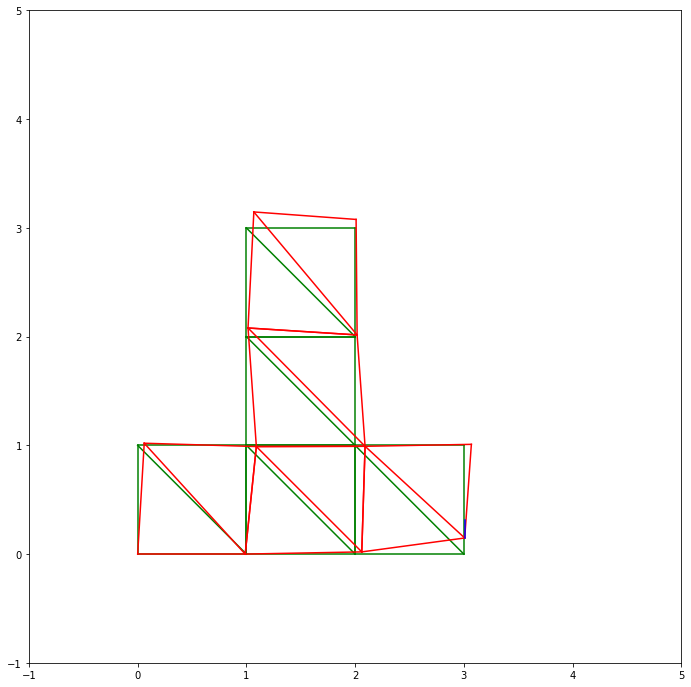

In [476]:
eps = np.concatenate((np.array([[0], [0]] + [epsBack[0]] + [[0]]), epsBack[1:]), axis=0)
f = np.concatenate((np.array([[0], [0]] + [fBack[0]] + [[0]]), fBack[1:]), axis=0)

positions = [
    (0, 0), (1, 0), (2, 0), (3, 0), (4, 0),
    (0, 1), (1, 1), (2, 1), (3, 1), (4, 1),
]

positions = positionsIn

squares = [
    [0, 1, 6, 5, 0],
    [1, 2, 7, 6, 1],
    [2, 3, 8, 7, 2],
    [3, 4, 9, 8, 3]
]
squares = []
for x in range(Field.shape[0]):
    for y in range(Field.shape[1]):
        if Field[x, y]:
            row = []
            for edge in edgesOnRectangle:
                pos = edge + (x, y)
                pos = (pos[0], pos[1])
                i = positionsIn.index(pos)
                row.append(i)
            row.append(row[0])
            squares.append(row)
scale = 0.1
plt.figure(figsize=(12, 12))
for square in squares:
    for i in range(4):
        startI = square[i]
        endI = square[i + 1]
        plt.plot(
            [positions[startI][0], positions[endI][0]],
            [positions[startI][1], positions[endI][1]],
            color='g'
            )
    startI = square[1]
    endI = square[3]
    plt.plot(
        [positions[startI][0], positions[endI][0]],
        [positions[startI][1], positions[endI][1]],
            color='g'
        )
for square in squares:
    for i in range(4):
        startI = square[i]
        endI = square[i + 1]
        plt.plot(
            [positions[startI][0] + eps[2 * startI, 0]*scale, positions[endI][0] + eps[2 * endI, 0]*scale],
            [positions[startI][1] + eps[2 * startI + 1, 0]*scale, positions[endI][1] + eps[2 * endI + 1, 0]*scale],
            color='r'
            )
    startI = square[1]
    endI = square[3]
    plt.plot(
        [positions[startI][0] + eps[2 * startI, 0]*scale, positions[endI][0] + eps[2 * endI, 0]*scale],
        [positions[startI][1] + eps[2 * startI + 1, 0]*scale, positions[endI][1] + eps[2 * endI + 1, 0]*scale],
            color='r'
        )
plt.xlim([-1, 5])
plt.ylim([-1, 5])
plt.gca().set_aspect(1)
for i in range(len(positions)):
    pos = np.array(positions[i]) + [eps[2 * i, 0]*scale, eps[2 * i + 1, 0]*scale]
    plt.plot([pos[0], pos[0] + f[2 * i, 0] / 60.], [pos[1], pos[1]], color='b')
    plt.plot([pos[0], pos[0]], [pos[1], pos[1] + f[2 * i + 1, 0] / 60.], color='b')
    i += 1
f.shape, eps.shape, len(positions)

In [477]:
eps

array([[ 0.   ],
       [ 0.   ],
       [-0.109],
       [ 0.   ],
       [ 0.916],
       [-0.109],
       [ 0.604],
       [ 0.196],
       [ 0.613],
       [ 0.202],
       [ 0.917],
       [-0.085],
       [ 0.184],
       [ 0.157],
       [ 0.151],
       [ 0.796],
       [ 0.091],
       [ 0.78 ],
       [ 0.685],
       [ 1.47 ],
       [ 0.08 ],
       [ 1.48 ],
       [ 0.693],
       [ 0.093]])

In [479]:
q = eps # Naming error

Aq = []
sigma2 = []
for x in range(Field.shape[0]):
    for y in range(Field.shape[1]):
        if Field[x, y]:
            evenI = lambda pos: positionsIn.index((x + pos[0], y + pos[1])) * 2
            oddI = lambda pos: positionsIn.index((x + pos[0], y + pos[1])) * 2 + 1

            targetIndices = [evenI((0, 0)), oddI((0, 0)), evenI((1, 0)), oddI((1, 0)), evenI((0, 1)), oddI((0, 1))]
            qLocal = np.array([q[i] for i in targetIndices])
            print(targetIndices, qLocal)
            Aq.append(qLocal)
            sigma2.append(E @ B @ qLocal)

            targetIndices = [evenI((1, 1)), oddI((1, 1)), evenI((0, 1)), oddI((0, 1)), evenI((1, 0)), oddI((1, 0))]
            qLocal = np.array([q[i] for i in targetIndices])
            Aq.append(qLocal)
            sigma2.append(E @ B @ qLocal)
Aq = np.array(Aq)
print(Aq.shape)
sigma2 = np.array(sigma2)

sigma = E[None, :] @ B[None, :] @ Aq
sigma.shape, sigma2.shape

[0, 1, 2, 3, 6, 7] [[ 0.   ]
 [ 0.   ]
 [-0.109]
 [ 0.   ]
 [ 0.604]
 [ 0.196]]
[2, 3, 8, 9, 4, 5] [[-0.109]
 [ 0.   ]
 [ 0.613]
 [ 0.202]
 [ 0.916]
 [-0.109]]
[4, 5, 10, 11, 14, 15] [[ 0.916]
 [-0.109]
 [ 0.917]
 [-0.085]
 [ 0.151]
 [ 0.796]]
[14, 15, 12, 13, 18, 19] [[0.151]
 [0.796]
 [0.184]
 [0.157]
 [0.685]
 [1.47 ]]
[8, 9, 20, 21, 10, 11] [[ 0.613]
 [ 0.202]
 [ 0.08 ]
 [ 1.48 ]
 [ 0.917]
 [-0.085]]
(10, 6, 1)


((10, 3, 1), (10, 3, 1))

In [442]:
E @ B

array([[-240., -120.,  240.,    0.,    0.,  120.],
       [-120., -240.,  120.,    0.,    0.,  240.],
       [ -60.,  -60.,    0.,   60.,   60.,    0.]])

In [443]:
sigma2

array([[[  -2.689],
        [  34.004],
        [  36.211]],

       [[ -61.958],
        [ -11.342],
        [ -43.208]],

       [[ 160.248],
        [  60.487],
        [  73.627]],

       [[  34.343],
        [  68.793],
        [ -19.648]],

       [[ 108.658],
        [ 217.208],
        [ -44.475]],

       [[ -36.986],
        [ -62.101],
        [  82.272]],

       [[  88.802],
        [ 165.732],
        [  -6.281]],

       [[  67.87 ],
        [ -78.292],
        [  46.966]],

       [[-162.18 ],
        [-132.712],
        [  94.936]],

       [[ 220.092],
        [ 359.722],
        [ -47.449]]])

In [444]:
sigma_v = np.sqrt(sigma[:, 0] ** 2 + sigma[:, 1] ** 2 + sigma[:, 0] * sigma[:, 1] + 3 * (sigma[:, 2] ** 2))
sigma_v ** 2

array([[  5005.654],
       [ 10271.011],
       [ 55293.587],
       [  9432.651],
       [ 88521.602],
       [ 27827.302],
       [ 50188.747],
       [ 12039.752],
       [ 92476.761],
       [263766.486]])

In [73]:
K = np.array([
[   3e+02, 1.8e+02,-2.4e+02,     -60,       0,       0,     -60,-1.2e+02,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[ 1.8e+02,   3e+02,-1.2e+02,     -60,       0,       0,     -60,-2.4e+02,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[-2.4e+02,-1.2e+02,   6e+02, 1.8e+02,-1.2e+02,-1.8e+02,       0, 1.8e+02,       0,       0,       0,       0,-2.4e+02,     -60,       0,       0,       0,       0,       0,       0,       0],
[     -60,     -60, 1.8e+02,   6e+02,-1.8e+02,-4.8e+02, 1.8e+02,       0,       0,       0,       0,       0,-1.2e+02,     -60,       0,       0,       0,       0,       0,       0,       0],
[       0,       0,-1.2e+02,-1.8e+02,   9e+02, 1.8e+02,-4.8e+02,-1.8e+02,     -60,     -60,       0, 1.8e+02,       0, 1.8e+02,-2.4e+02,-1.2e+02,       0,       0,       0,       0,       0],
[       0,       0,-1.8e+02,-4.8e+02, 1.8e+02,   9e+02,-1.8e+02,-1.2e+02,-1.2e+02,-2.4e+02, 1.8e+02,       0, 1.8e+02,       0,     -60,     -60,       0,       0,       0,       0,       0],
[     -60,     -60,       0, 1.8e+02,-4.8e+02,-1.8e+02,   6e+02, 1.8e+02,       0,       0,     -60,-1.2e+02,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[-1.2e+02,-2.4e+02, 1.8e+02,       0,-1.8e+02,-1.2e+02, 1.8e+02,   6e+02,       0,       0,     -60,-2.4e+02,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[       0,       0,       0,       0,     -60,-1.2e+02,       0,       0,   3e+02, 1.8e+02,-2.4e+02,     -60,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[       0,       0,       0,       0,     -60,-2.4e+02,       0,       0, 1.8e+02,   3e+02,-1.2e+02,     -60,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[       0,       0,       0,       0,       0, 1.8e+02,     -60,     -60,-2.4e+02,-1.2e+02,   3e+02,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[       0,       0,       0,       0, 1.8e+02,       0,-1.2e+02,-2.4e+02,     -60,     -60,       0,   3e+02,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[       0,       0,-2.4e+02,-1.2e+02,       0, 1.8e+02,       0,       0,       0,       0,       0,       0,   9e+02, 1.8e+02,-1.2e+02,-1.8e+02,     -60,     -60,       0, 1.8e+02,-4.8e+02],
[       0,       0,     -60,     -60, 1.8e+02,       0,       0,       0,       0,       0,       0,       0, 1.8e+02,   9e+02,-1.8e+02,-4.8e+02,-1.2e+02,-2.4e+02, 1.8e+02,       0,-1.8e+02],
[       0,       0,       0,       0,-2.4e+02,     -60,       0,       0,       0,       0,       0,       0,-1.2e+02,-1.8e+02,   6e+02, 1.8e+02,       0,       0,       0,       0,       0],
[       0,       0,       0,       0,-1.2e+02,     -60,       0,       0,       0,       0,       0,       0,-1.8e+02,-4.8e+02, 1.8e+02,   6e+02,       0,       0,       0,       0, 1.8e+02],
[       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,     -60,-1.2e+02,       0,       0,   3e+02, 1.8e+02,-2.4e+02,     -60,       0],
[       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,     -60,-2.4e+02,       0,       0, 1.8e+02,   3e+02,-1.2e+02,     -60,       0],
[       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0, 1.8e+02,       0,       0,-2.4e+02,-1.2e+02,   3e+02,       0,     -60],
[       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0, 1.8e+02,       0,       0,       0,     -60,     -60,       0,   3e+02,-1.2e+02],
[       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,-4.8e+02,-1.8e+02,       0, 1.8e+02,       0,       0,     -60,-1.2e+02,   6e+02],
])

In [77]:
np.linalg.matrix_rank(K)

20

In [78]:
K.shape

(21, 21)